# Finding similar images

Imagine you are an insurance company that insures cars. Nowadays it is normal that customers and garages submit pictures of the damage reports to get the costs for the damage reimbursed.

But of course we have to check that damage is not reported more than once to prevent fraud.

Simple approaches aim to generate hash values for images and compare them with each other.
This variant is easy to implement and very performant. Unfortunately it is also not really robust if the images have been slightly modified.

SAS has therefore implemented several more complex methods to determine the similarity of two images.
I would like to introduce some of them here using two different CAS actions:

### [compareImages action](https://documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.5&docsetId=casactml&docsetTarget=cas-image-compareimages.htm&locale=en)
* Structural Similarity (SSIM)
* Peak Signal-to-Noise Ratio (PSNR)

### [matchImages action](https://documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.5&docsetId=casactml&docsetTarget=cas-image-matchimages.htm&locale=en)
* Template Matching
* Descriptor Matching

### Connect to SAS Viya

In [1]:
# Imports
from IPython.display import display
from swat import CAS
from dlpy.images import ImageTable

In [2]:
# Connect to SAS Viya Platform
s = CAS(hostname='localhost', port=5570, username='sas', password='saspw')
s.setsessopt(messagelevel='NONE')

+ Elapsed: 0.00023s, user: 9.2e-05s, sys: 5.8e-05s, mem: 0.256mb

### Load image data
Our database consists of 3 existing, different images.<br>
We receive three new images from a customer that should be marked as a duplicate:
1. Exact copy
2. Cropped image
2. Flipped image

Existing images in database:


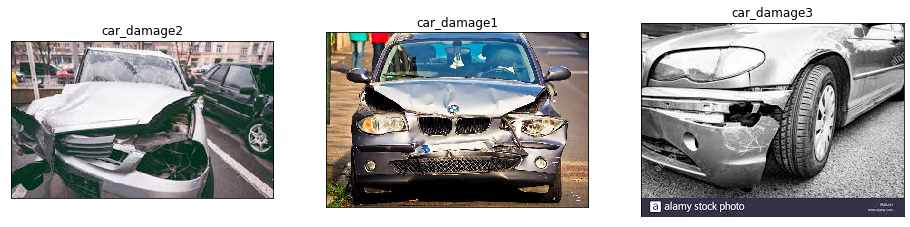

New images from customer:


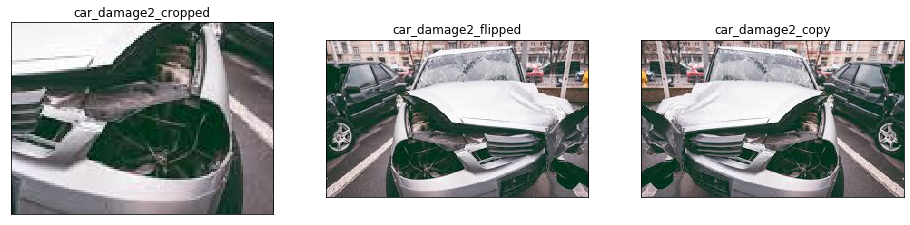

In [3]:
# Load existing images
existing_images  = ImageTable.load_files(s, 
                                         columns=['_path_'],
                                         path='/data/notebooks/SAS_MiscExamples/Finding_duplicate_images/existing_images/')
print('Existing images in database:')
existing_images.show(randomize=False)

# Load new images from customers
new_images = ImageTable.load_files(s, 
                                   columns=['_path_'],
                                   path='/data/notebooks/SAS_MiscExamples/Finding_duplicate_images/new_images/')
print('New images from customer:')
new_images.show(randomize=False)

### Peak Signal-to-Noise Ratio (PSNR)
Compare Images using Peak Signal-to-Noise Ratio (PSNR)


Comparison of Images:


,_channel1_,_channel2_,_channel3_,_channel4_,_source_id_,_reference_id_
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage2.jpeg,car_damage2_cropped.png
1,8.464870e+00,9.057295e+00,7.733949e+00,1.797693e+308,car_damage2.jpeg,car_damage2_flipped.png
2,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,car_damage2.jpeg,car_damage2_copy.jpeg
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage1.jpg,car_damage2_cropped.png
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage1.jpg,car_damage2_flipped.png
5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage1.jpg,car_damage2_copy.jpeg
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage3.jpeg,car_damage2_cropped.png
7,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage3.jpeg,car_damage2_flipped.png
8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage3.jpeg,car_damage2_copy.jpeg



Duplicates of Images:


,_channel1_,_channel2_,_channel3_,_channel4_,_source_id_,_reference_id_
0,8.464870e+00,9.057295e+00,7.733949e+00,1.797693e+308,car_damage2.jpeg,car_damage2_flipped.png
1,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,car_damage2.jpeg,car_damage2_copy.jpeg



Visualized Duplicates:


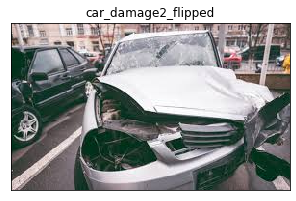

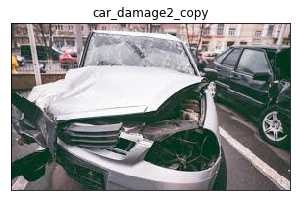

In [4]:
# Run compareimages action with PSNR as method
compare_table = s.compareimages(sourceimages=existing_images.name, 
                                referenceimages=new_images.name, 
                                pairall=True, 
                                method='PSNR',
                                casout=dict(name='comparison_psnr', replace=True))['OutputCasTables']['casTable'][0]
print('\nComparison of Images:')
display(compare_table.to_frame())

# Filter for duplicates with channel-similarity > threshold
threshold = 0.1
duplicates = compare_table[(compare_table['_channel1_'] > threshold) or 
                           (compare_table['_channel2_'] > threshold) or 
                           (compare_table['_channel3_'] > threshold)]
duplicates = duplicates[duplicates._source_id_ != duplicates._reference_id_].head()
print('\nDuplicates of Images:')
display(duplicates)

print('\nVisualized Duplicates:')
for match in duplicates['_reference_id_']:
    new_images.show(figsize=(5,5), where='_filename_0 = "{}"'.format(match))

### Structural Similarity (SSIM)
Compare Images using Structural Similarity (SSIM)


Comparison of Images:


,_channel1_,_channel2_,_channel3_,_channel4_,_source_id_,_reference_id_
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage2.jpeg,car_damage2_cropped.png
1,8.464870e+00,9.057295e+00,7.733949e+00,1.797693e+308,car_damage2.jpeg,car_damage2_flipped.png
2,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,car_damage2.jpeg,car_damage2_copy.jpeg
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage1.jpg,car_damage2_cropped.png
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage1.jpg,car_damage2_flipped.png
5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage1.jpg,car_damage2_copy.jpeg
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage3.jpeg,car_damage2_cropped.png
7,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage3.jpeg,car_damage2_flipped.png
8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,car_damage3.jpeg,car_damage2_copy.jpeg



Duplicates of Images:


,_channel1_,_channel2_,_channel3_,_channel4_,_source_id_,_reference_id_
0,8.464870e+00,9.057295e+00,7.733949e+00,1.797693e+308,car_damage2.jpeg,car_damage2_flipped.png
1,1.797693e+308,1.797693e+308,1.797693e+308,1.797693e+308,car_damage2.jpeg,car_damage2_copy.jpeg



Visualized Duplicates:


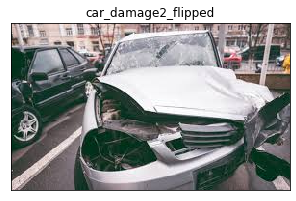

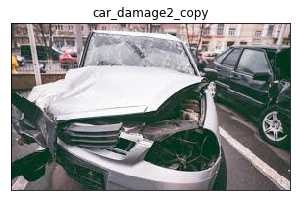

In [5]:
# Run compareimages action
compare_table = s.compareimages(sourceimages=existing_images.name, 
                                referenceimages=new_images.name, 
                                pairall=True, 
                                method='PSNR',
                                casout=dict(name='comparison_ssim', replace=True))['OutputCasTables']['casTable'][0]
print('\nComparison of Images:')
display(compare_table.to_frame())

# Filter for duplicates with channel-similarity > threshold
threshold = 0.1
duplicates = compare_table[(compare_table['_channel1_'] > threshold) or 
                           (compare_table['_channel2_'] > threshold) or 
                           (compare_table['_channel3_'] > threshold)]
duplicates = duplicates[duplicates._source_id_ != duplicates._reference_id_].head()
print('\nDuplicates of Images:')
display(duplicates)

print('\nVisualized Duplicates:')
for match in duplicates['_reference_id_']:
    new_images.show(figsize=(5,5), where='_filename_0 = "{}"'.format(match))

### Template Matching
Compare images against a template image

car_damage2_cropped
car_damage2_cropped.png
################################################################################

Query Image: car_damage2_cropped.png



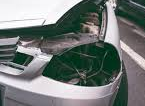


Similar Images in existing database:


,_image_,_path_,_id_,x,y,score,_label_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,/data/notebooks/SAS_MiscExamples/Finding_dupli...,1,96,68,0.999929,car_damage2



Matches visualized:


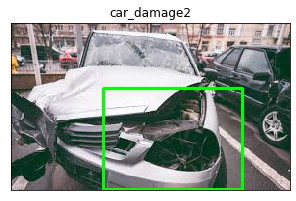

car_damage2_flipped
car_damage2_flipped.png
################################################################################

Query Image: car_damage2_flipped.png



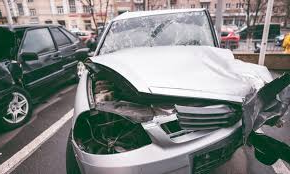


No Match found.

car_damage2_copy
car_damage2_copy.jpeg
################################################################################

Query Image: car_damage2_copy.jpeg



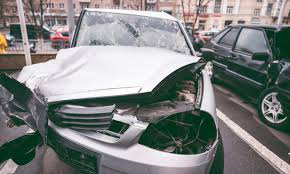


Similar Images in existing database:


,_image_,_path_,_id_,x,y,score,_label_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,/data/notebooks/SAS_MiscExamples/Finding_dupli...,1,0,0,0.999944,car_damage2



Matches visualized:


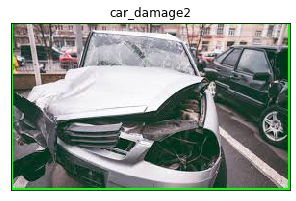

In [14]:
# The compareImages action needs query images inside a CAS library
# We can simply save them using the saveimages action
subdirectory = 'customer_images'
s.saveimages(caslib='casuser', subdirectory=subdirectory, images=new_images.name, labellevels=1)

# Each image is inside its own class-folder
# Loop through alle files and make sure its an image file
imagefiles = ['jpg','jpeg','png']
threshold = 0.8
for directory in s.fileinfo(path='{}'.format(subdirectory), includedirectories=True)['FileInfo']['Name']:
    print(directory)
    for file in s.fileinfo(path='{}/{}/'.format(subdirectory,directory), allfiles=True)['FileInfo']['Name']:
        print(file)
        if file.split('.')[1] in imagefiles:
            print('#'*80)
            print('\nQuery Image: {}\n'.format(file))
            display(new_images.fetchimages()['Images'].loc[new_images.fetchimages()['Images'].Label == file.split('.')[0]]['Image'].iloc[0])
            # Run matchimages action with query image
            compare_table2 = s.image.matchImages(casout=dict(name='comparison2', replace=True),
                                                 image="{}/{}/{}".format(subdirectory,directory,file),
                                                 threshold=threshold,
                                                 highlight=True,
                                                 table=existing_images)['OutputCasTables']['casTable'][0]
            if compare_table2.numrows()['numrows'] > 0:
                print('\nSimilar Images in existing database:')
                display(compare_table2.to_frame())
                print('\nMatches visualized:')
                ImageTable.from_table(compare_table2).show(figsize=(5,5))
            else:
                print('\nNo Match found.\n')

### Descriptor Matching
Compare images against a query image using Descriptor Matching

car_damage2_cropped
car_damage2_cropped.png
################################################################################

Query Image: car_damage2_cropped.png



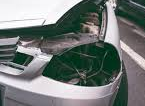


Similar Images in existing database:


,_image_,_path_,_id_,x,y,score,_label_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,/data/notebooks/SAS_MiscExamples/Finding_dupli...,1,110,88,0.620047,car_damage2



Matches visualized:


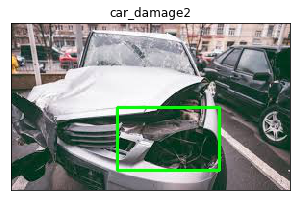

car_damage2_flipped
car_damage2_flipped.png
################################################################################

Query Image: car_damage2_flipped.png



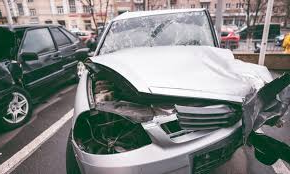


No Match found.

car_damage2_copy
car_damage2_copy.jpeg
################################################################################

Query Image: car_damage2_copy.jpeg



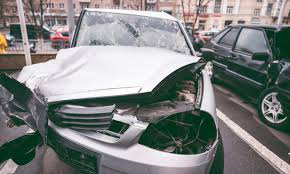


Similar Images in existing database:


,_image_,_path_,_id_,x,y,score,_label_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,/data/notebooks/SAS_MiscExamples/Finding_dupli...,1,20,14,0.96918,car_damage2



Matches visualized:


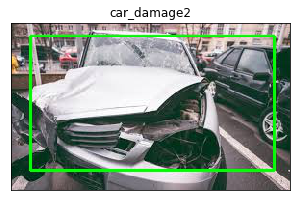

In [15]:
# The compareImages action needs query images inside a CAS library
# We can simply save them using the saveimages action
subdirectory = 'customer_images'
s.saveimages(caslib='casuser', subdirectory=subdirectory, images=new_images.name, labellevels=1)

# Each image is inside its own class-folder
# Loop through alle files and make sure its an image file
imagefiles = ['jpg','jpeg','png']
threshold = 0.15
for directory in s.fileinfo(path='{}'.format(subdirectory), includedirectories=True)['FileInfo']['Name']:
    print(directory)
    for file in s.fileinfo(path='{}/{}/'.format(subdirectory,directory), allfiles=True)['FileInfo']['Name']:
        print(file)
        if file.split('.')[1] in imagefiles:
            print('#'*80)
            print('\nQuery Image: {}\n'.format(file))
            display(new_images.fetchimages()['Images'].loc[new_images.fetchimages()['Images'].Label == file.split('.')[0]]['Image'].iloc[0])
            # Run matchimages action with query image
            compare_table2 = s.image.matchImages(casout=dict(name='comparison2', replace=True),
                                                 image="{}/{}/{}".format(subdirectory,directory,file),
                                                 threshold=0.15,
                                                 highlight=True,
                                                 methodoptions={
                                                     'desctype':'ORB_BRISK',
                                                     'method':'descriptorMatch',
                                                     'thresholdratio':0.5
                                                 },
                                                 table=existing_images)['OutputCasTables']['casTable'][0]
            if compare_table2.numrows()['numrows'] > 0:
                print('\nSimilar Images in existing database:')
                display(compare_table2.to_frame())
                print('\nMatches visualized:')
                ImageTable.from_table(compare_table2).show(figsize=(5,5))
            else:
                print('\nNo Match found.\n')